In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Capstone/Food ingredients.v1i.tensorflow.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
!pip install tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import to_categorical


In [10]:
annotations_path = '/content/dataset/train/_annotations.csv'  # Path to your annotations CSV
images_path = '/content/dataset/train/'  # Directory containing images

annotations = pd.read_csv(annotations_path)

target_size = (224, 224)

def load_and_preprocess_image(img_path, bbox, target_size):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = preprocess_input(img)
    return img, bbox

def parse_annotation(row):
    img_path = os.path.join(images_path, row['filename'])
    xmin = row['xmin'] / row['width']
    ymin = row['ymin'] / row['height']
    xmax = row['xmax'] / row['width']
    ymax = row['ymax'] / row['height']
    bbox = [xmin, ymin, xmax, ymax]
    class_id = row['class']
    return img_path, bbox, class_id

annotations['img_path'], annotations['bbox'], annotations['class_id'] = zip(*annotations.apply(parse_annotation, axis=1))

# Split the dataset
train_annotations, test_annotations = train_test_split(annotations, test_size=0.2, random_state=42)

In [11]:
def create_dataset(annotations, target_size, batch_size=32):
    def gen():
        for index, row in annotations.iterrows():
            img_path = row['img_path']
            bbox = row['bbox']
            class_id = row['class_id']
            yield img_path, bbox, class_id

    def load_and_preprocess_from_path_label(img_path, bbox, class_id):
        img, bbox = load_and_preprocess_image(img_path.numpy().decode(), bbox, target_size)
        return img, tf.one_hot(class_id, depth=len(annotations['class_id'].unique())), bbox

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(4,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )
    dataset = dataset.map(lambda img_path, bbox, class_id: tf.py_function(
        load_and_preprocess_from_path_label, [img_path, bbox, class_id],
        [tf.float32, tf.float32, tf.float32]
    ), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda img, class_id, bbox: (img, {'class_output': class_id, 'bbox_output': bbox}), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

batch_size = 32
train_dataset = create_dataset(train_annotations, target_size, batch_size).repeat()
test_dataset = create_dataset(test_annotations, target_size, batch_size).repeat()


In [12]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Bounding box regression
bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)

# Classification output
class_output = Dense(len(annotations['class_id'].unique()), activation='softmax', name='class_output')(x)

model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])

for layer in base_model.layers:
    layer.trainable = False


In [13]:
model.compile(optimizer='adam',
              loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mean_squared_error'},
              metrics={'class_output': ['accuracy'], 'bbox_output': ['mse']},
              run_eagerly=True)


In [18]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [19]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    steps_per_epoch=len(train_annotations) // batch_size,
                    validation_steps=len(test_annotations) // batch_size)


Epoch 1/10
560/560 [==============================] - 203s 355ms/step - loss: 0.2890 - class_output_loss: 0.2518 - bbox_output_loss: 0.0372 - class_output_accuracy: 0.9342 - bbox_output_mse: 0.0372 - val_loss: 0.0925 - val_class_output_loss: 0.0624 - val_bbox_output_loss: 0.0302 - val_class_output_accuracy: 0.9859 - val_bbox_output_mse: 0.0302
Epoch 2/10
560/560 [==============================] - 174s 310ms/step - loss: 0.0840 - class_output_loss: 0.0551 - bbox_output_loss: 0.0288 - class_output_accuracy: 0.9867 - bbox_output_mse: 0.0288 - val_loss: 0.0680 - val_class_output_loss: 0.0397 - val_bbox_output_loss: 0.0283 - val_class_output_accuracy: 0.9897 - val_bbox_output_mse: 0.0283
Epoch 3/10
560/560 [==============================] - 192s 342ms/step - loss: 0.0622 - class_output_loss: 0.0347 - bbox_output_loss: 0.0275 - class_output_accuracy: 0.9922 - bbox_output_mse: 0.0275 - val_loss: 0.0604 - val_class_output_loss: 0.0326 - val_bbox_output_loss: 0.0278 - val_class_output_accuracy:

In [23]:
batch_size = 32  # set your batch size
steps = 312  # set a fixed number of steps based on your estimation

results = model.evaluate(test_dataset, steps=steps)
print("Test Loss, Test Class Loss, Test Bbox Loss, Test Class Accuracy, Test Bbox MSE:", results)


312/312 [==============================] - 60s 192ms/step - loss: 0.0525 - class_output_loss: 0.0249 - bbox_output_loss: 0.0276 - class_output_accuracy: 0.9916 - bbox_output_mse: 0.0276
Test Loss, Test Class Loss, Test Bbox Loss, Test Class Accuracy, Test Bbox MSE: [0.0524868406355381, 0.02486979030072689, 0.027617037296295166, 0.9916364550590515, 0.027617037296295166]


In [24]:
model.save('/content/drive/MyDrive/ARSIP KULIAH/mobilenet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# from keras.models import load_model
# model = load_model('my_model.keras')

In [41]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ARSIP KULIAH/mobilenet_model.h5')

def predict_image(img_path, model, target_size):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    class_pred, bbox_pred = model.predict(img)
    class_id = np.argmax(class_pred)
    return class_id, bbox_pred

img_path = '/content/dataset/train/11_jpg.rf.e7475fe1754205b2bdb32d971eeac596.jpg'
class_id, bbox_pred = predict_image(img_path, model, target_size)

1/1 [==============================] - 0s 398ms/step


In [2]:
# base_model.summary()

In [ ]:
# model.summary()

In [42]:
items = [
    "Kentang",       # 0
    "Tomat",         # 1
    "Timun jepang",  # 2
    "Bawang bombay", # 3
    "Lobak",         # 4
    "Terong",        # 5
    "Daun bawang",   # 6
    "Kol ungu",      # 7
    "Wortel",        # 8
    "Telur",         # 9
    "Daging sapi",   # 10
    "Pork",          # 11
    "Daging ayam"    # 12
]

predicted = items[class_id]
print(f"Predicted Class: {predicted}, Bounding Box: {bbox_pred}")

Predicted Class: daun bawang, Bounding Box: [[0.09170754 0.04158445 0.9353308  0.9180934 ]]


1/1 [==============================] - 0s 20ms/step
Predicted Class: tomat, Bounding Box: [[0.25225326 0.11998562 0.8339146  0.8341798 ]]


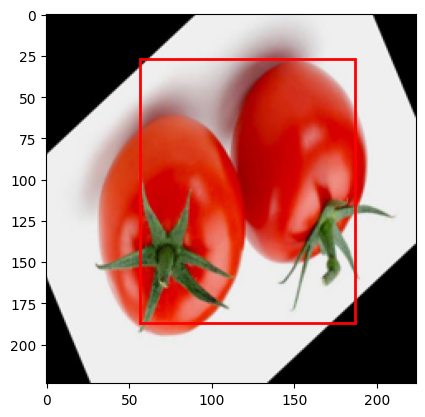

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input

def predict_image(img_path, model, target_size):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    class_pred, bbox_pred = model.predict(img)
    class_id = np.argmax(class_pred)
    return class_id, bbox_pred

def display_image_with_bbox(img_path, bbox, target_size):
    img = Image.open(img_path)
    img = img.resize(target_size)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Bounding box coordinates
    x_min, y_min, x_max, y_max = bbox[0]
    width = x_max - x_min
    height = y_max - y_min

    # Create a Rectangle patch
    rect = patches.Rectangle((x_min * target_size[0], y_min * target_size[1]),
                             width * target_size[0], height * target_size[1],
                             linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()

# Path to the image
img_path = '/content/dataset/train/istockphoto-1126929591-612x612_jpg.rf.09e1e2f9a743fcedbc1bb7a2dcf67a7d.jpg'
target_size = (224, 224)

# Predict class and bounding box
class_id, bbox_pred = predict_image(img_path, model, target_size)
predicted = items[class_id]
print(f"Predicted Class: {predicted}, Bounding Box: {bbox_pred}")

# Display the image with bounding box
display_image_with_bbox(img_path, bbox_pred, target_size)
